In [1]:
import numpy as np
import os
import h5py
from getdist import plots, MCSamples
import getdist
import dynesty 

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import plotter
import utils

In [2]:
cwp = 'deepskyblue'
cupf = 'green'
cmcf = 'magenta'

In [3]:
param_labels = {'Omega_m': '\Omega_m', 
                'Omega_b': '\Omega_b', 
                'sigma_8': '\sigma_8', 
                'h': 'h', 
                'n_s': 'n_s',
                'N_eff': 'N_{eff}', 
                'w': 'w', 
                'M_sat': 'M_{sat}', 
                'alpha': r'\alpha', 
                'M_cut': 'M_{cut}', 
                'sigma_logM': '\sigma_{logM}', 
                'v_bc': 'v_{bc}', 
                'v_bs': 'v_{bs}', 
                'c_vir': 'c_{vir}', 
                'f': 'f', 
                'f_env': 'f_{env}', 
                'delta_env': '\delta_{env}', 
                'sigma_env': '\sigma_{env}'}

In [4]:
cosmo_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w']
hod_params = ['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f']
ab_params = ['f_env', 'delta_env', 'sigma_env']
hod_interest = ['M_sat', 'M_cut', 'alpha', 'f_env', 'delta_env']
all_interest = ['Omega_m', 'sigma_8', 'M_sat', 'f_env', 'delta_env']
key_params = ['Omega_m', 'sigma_8', 'M_sat', 'v_bc', 'v_bs', 'f', 'f_env']
all_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w', 'M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f', 'f_env', 'delta_env', 'sigma_env']

In [5]:
def check_chains(chaintag): 
    chain_fn = f'../chains/chains_{chaintag}.h5'
    if os.path.exists(chain_fn):
        fw = h5py.File(chain_fn, 'r')
        chain_dset = fw['chain']
        print(f"{chaintag}: {chain_dset}")
        print(f"dlogz: {fw.attrs['dlogz']}")
        print(f"seed: {fw.attrs['seed']}")
        fw.close()
    else:
        print(f"chain {chain_fn} doesn't exist!")

In [6]:
def plot_chains(chaintag, show_walkers=False, show_params=None, figure=None, nsteps=None, color='blue'): 
    #chaintag = 'wp_c3h3_Msat_fenv_xlong_diag'
    chain_fn = f'../chains/chains_{chaintag}.h5'
    fw = h5py.File(chain_fn, 'r')

    chain_dset = fw['chain']
    print(chain_dset)
    chain = np.array(chain_dset)
    lnprob_dset = fw['lnprob']
    lnprob = np.array(lnprob_dset)
    param_names = fw.attrs['param_names']
    true_values = fw.attrs['true_values']
    if nsteps:
        chain = chain[:,:nsteps,:]
    fw.close()
    
    if show_params:    
        idxs = []
        for sp in show_params:
            idxs.append(np.where(param_names == sp))
        idxs = np.array(idxs).flatten()
        chain = chain[:,:,idxs]
        param_names = show_params
        true_values = true_values[idxs]

    nwalkers, nchain, ndim = chain.shape

    for k in range(ndim):
        plt.figure()
        pname = param_names[k]
        for j in range(nwalkers):
            plt.title(pname)
            plt.plot(chain[j,:,k], alpha=1)
            low, high = bounds[pname]
            plt.axhline(low, ls=':', color='k')
            plt.axhline(high, ls=':', color='k')
            plt.axhline(true_values[k], ls='-', lw=2, color='k')
    plt.xlabel('step')

    plt.figure()
    for j in range(nwalkers):
        plt.plot(lnprob[j,:], alpha=1)
    plt.ylabel('lnprob')
    plt.xlabel('step')

In [13]:
def plot_contours(chaintags, legend_labels=None, params_toplot=None, nsteps=None, colors=None, 
                  legend_loc='upper center', legend_fontsize=20, weight_with_dynesty=False): 
    
    sample_arr = []
    for i, chaintag in enumerate(chaintags):
        
        resample_chains = False
        if 'dynesty' in chaintag:
            resample_chains = True
            assert not (nsteps!=None and resample_chains), "if resampling, shouldn't be selecting nsteps!"
    
        chain_fn = f'../chains/chains_{chaintag}.h5'
        fw = h5py.File(chain_fn, 'r')

        chain_dset = fw['chain']
        chain = np.array(chain_dset)
        if nsteps:
            chain = chain[:,:nsteps,:]
   
        lnprob_dset = fw['lnprob']  
        param_names = fw.attrs['param_names']
        true_values = fw.attrs['true_values']

        if params_toplot is not None:    
            idxs = []
            for pm in params_toplot:
                idxs.append(np.where(param_names == pm))
            idxs = np.array(idxs).flatten()
            chain = chain[:,:,idxs]
            param_names = params_toplot
            true_values = true_values[idxs]

        nwalkers, nchain, ndim = chain.shape
        
        samples = chain.reshape(-1, chain.shape[-1])
        labels = [param_labels[pn] for pn in param_names]
        ranges = [bounds[pn] for pn in param_names]

        if resample_chains:
            lnweight_dset = fw['lnweight']
            lnevidence_dset = fw['lnevidence']
            #[-1] bc just care about final evidence value
            lnweight = np.array(lnweight_dset)[0] #[0] bc an extra array dim
            lnevidence = np.array(lnevidence_dset)[0]
            weights = np.exp(lnweight - lnevidence[-1]) 
            weights = weights.flatten()
            
            samples = np.empty((nchain, ndim))
            for nd in range(ndim):
                cn = chain[:,:,nd].flatten()
                if weight_with_dynesty:
                    samples[:,nd] = dynesty.utils.resample_equal(cn, weights)
                else:
                    samples[:,nd] = cn
        
        fw.close()
        
        if weight_with_dynesty:
            weights = None
        
        # have not gotten ranges to work
        samps = MCSamples(names=param_names, labels=labels)#, ranges=ranges)
        # for some reason get slightly diff answer if don't use setSamples and pass them straight to MCSamples!
        samps.setSamples(samples, weights=weights)
        sample_arr.append(samps)

    g = plots.get_subplot_plotter()
    g.settings.alpha_filled_add=0.4
    g.settings.figure_legend_frame = False
    g.settings.legend_fontsize = legend_fontsize
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_color = 'dimgrey'
    g.triangle_plot(sample_arr, filled=True, contour_colors=colors, names=param_names,
                   legend_labels=legend_labels, markers=true_values, title_limit=1, legend_loc=legend_loc,
                   #marker_args={'color': 'orange', 'lw':1.5}
                   )
    return g

In [8]:
def plot_weights(chaintag): 
    
    chain_fn = f'../chains/chains_{chaintag}.h5'
    fw = h5py.File(chain_fn, 'r')
    
    lnweight_dset = fw['lnweight']
    lnevidence_dset = fw['lnevidence']
    #[-1] bc just care about final evidence value
    
    lnweight = np.array(lnweight_dset)[0] #bc accidentally a an extra array dim
    lnevidence = np.array(lnevidence_dset)[0]
    weights = np.exp(lnweight - lnevidence[-1]) 

    fw.close()

    plt.figure()
    plt.plot(weights)
    plt.xlabel('sample number')
    plt.ylabel('weight')

In [9]:
bounds = utils.get_emulator_bounds()

# initial tests

In [37]:
check_chains('wp_c3h3_omegam_dynesty_dynamic_nongen_seed12')

wp_c3h3_omegam_dynesty_dynamic_nongen_seed12: <HDF5 dataset "chain": shape (1, 15756, 1), type "<f4">
dlogz: 0.01
seed: 12


<HDF5 dataset "chain": shape (1, 15756, 1), type "<f4">


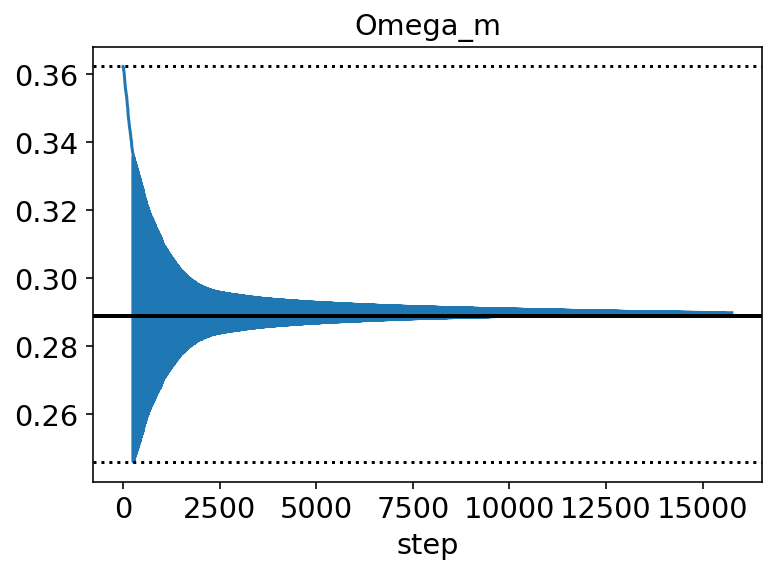

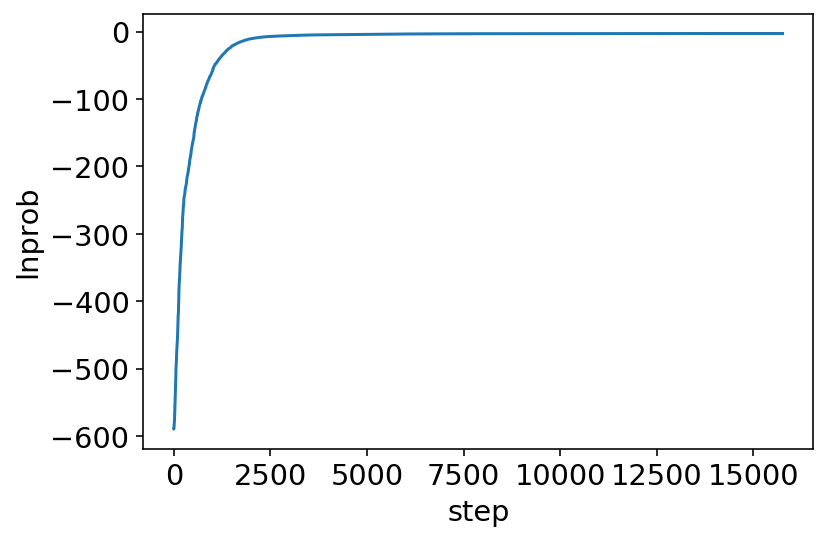

In [38]:
plot_chains('wp_c3h3_omegam_dynesty_dynamic_nongen_seed12')

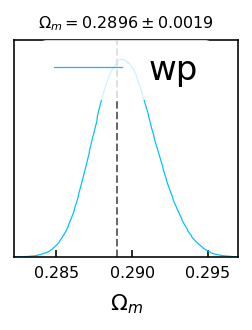

In [14]:
legend_labels = ['wp']
chaintags = ['wp_c3h3_omegam_dynesty_dynamic_nongen'] #this was only 30 iterations! and it's fine!
figure = plot_contours(chaintags, colors=[cwp], 
                      legend_labels=legend_labels)

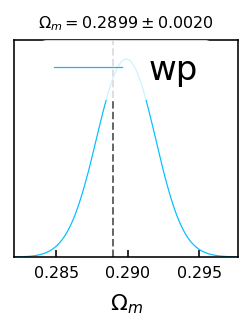

In [36]:
legend_labels = ['wp']
chaintags = ['wp_c3h3_omegam_dynesty_dynamic_nongen_seed12']
figure = plot_contours(chaintags, colors=[cwp], 
                      legend_labels=legend_labels)

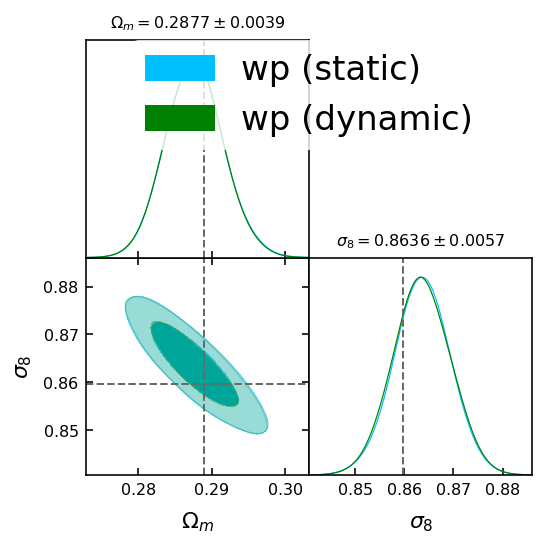

In [17]:
legend_labels = ['wp (static)', 'wp (dynamic)']
chaintags = ['wp_c3h3_omegam-sigma8_dynesty_dlogz001', #43 min
             'wp_c3h3_omegam-sigma8_dynesty_dynamic_nongen_seed12'] #90 min
figure = plot_contours(chaintags, colors=[cwp, 'green'], 
                      legend_labels=legend_labels)

3012
dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale'])
(3012, 1)
[0.24608166]


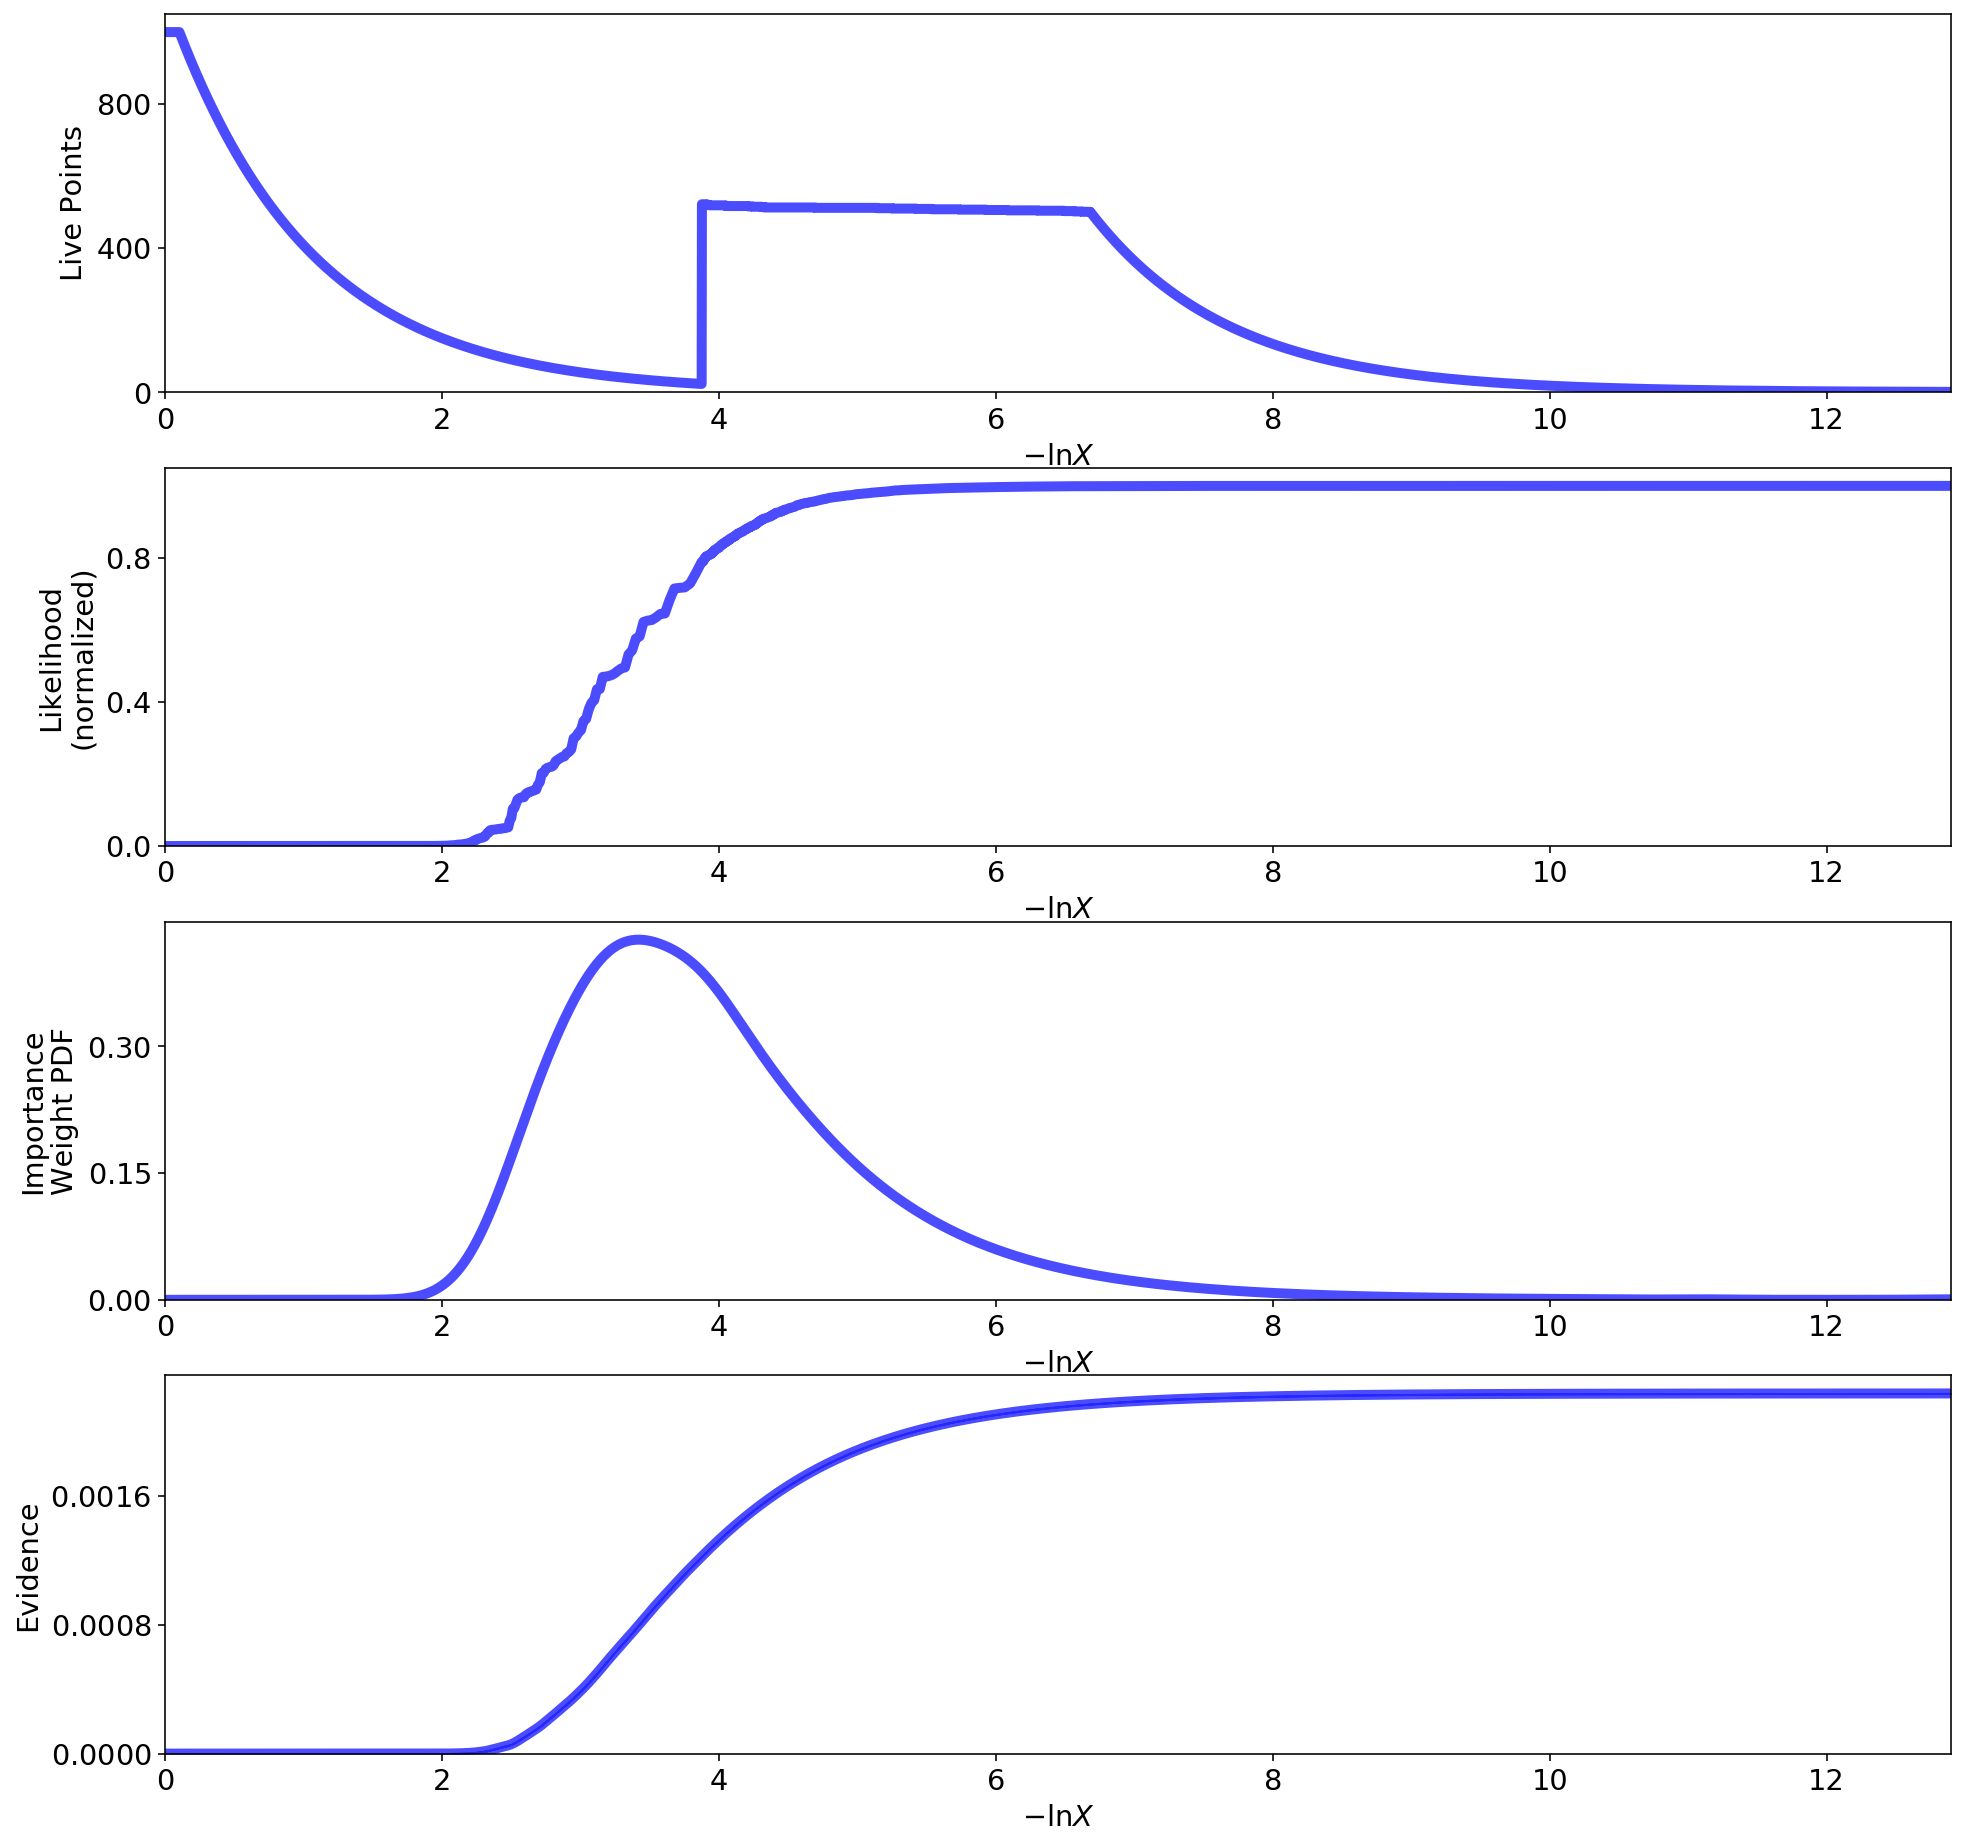

In [41]:
from dynesty import plotting as dyplot
import pickle
chaintag = 'chains_wp_c3h3_omegam_dynesty_dynamic_nongen_seed12_savetest'
n_batch = 1
pickle_dir = f'../products/dynesty_results/results_{chaintag}'
pickle_fn = f'{pickle_dir}/result_batch{n_batch}.pkl'
with open(pickle_fn, 'rb') as pf:
    res = pickle.load(pf)
    print(res.niter)
    print(res.keys())
    print(res.samples.shape)
    print(min(res.samples))
    #print(res.summary())
    #print(res.samples)
    dyplot.runplot(res)